#UAS Sistem Cerdas
Klasifikasi Citra Sel Kanker Serviks Menggunakan Metode ResNet-50

#langkah 1: Menginport Library Yang Dibutuhkan

Importing Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#Langkah 2: Mempersiapkan Data

prepare data

In [ ]:
data_dir = "/content/drive/MyDrive/UAS_Siscer/Data/Train"
data_dir = pathlib.Path(data_dir)

In [ ]:
print(data_dir)

/content/drive/MyDrive/UAS_Siscer/Data/Train


/content/drive/MyDrive/UAS_Siscer/Data/Train/normal_intermediate/157183332-157183388-001.BMP


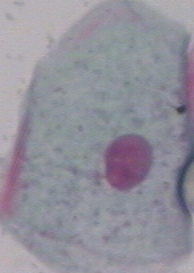

In [ ]:
#Mengambil satu contoh gambar pada folder Normal_intermediate
#Take one example of image from on eclass (Normal Intermediate)
sel = list(data_dir.glob('normal_intermediate/*'))
print(sel[0])
PIL.Image.open(str(sel[0]))

In [ ]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 615 files belonging to 5 classes.
Using 492 files for training.


In [ ]:
#Melakukan spliting data - data spliting
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 615 files belonging to 5 classes.
Using 123 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Kelas yang akan diprediksi:")
print(class_names)

Kelas yang akan diprediksi:
['carcinoma_in_situ', 'light_dysplastic', 'moderate_dysplastic', 'normal_intermediate', 'normal_superficiel']


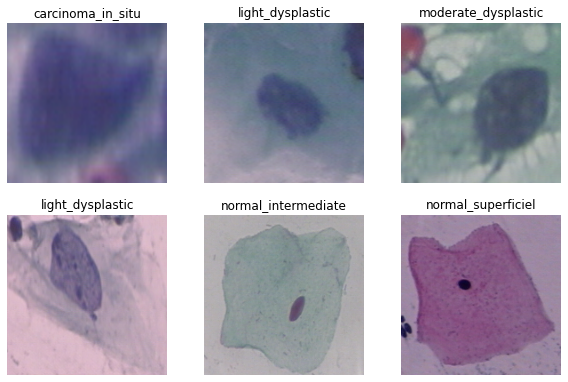

In [ ]:
#Memvisualisasikan data - visualize data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Langkah 3: Training Model

In [ ]:
#Menyusun Res-Net
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

In [ ]:
#model architecture
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 5)                2565      
 pper)                                                           
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
__________________________________

In [ ]:
resnet_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
#Melakukan training dengan 200 epoch - training with 200 epochs
epochs = 200 
history = resnet_model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/200
16/16 [==============================] - 2s 114ms/step - loss: 0.2444 - accuracy: 0.8984 - val_loss: 0.7828 - val_accuracy: 0.7480
Epoch 2/200
16/16 [==============================] - 2s 111ms/step - loss: 0.1551 - accuracy: 0.9654 - val_loss: 0.8240 - val_accuracy: 0.7561
Epoch 3/200
16/16 [==============================] - 2s 115ms/step - loss: 0.1407 - accuracy: 0.9553 - val_loss: 0.7512 - val_accuracy: 0.7561
Epoch 4/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0900 - accuracy: 0.9898 - val_loss: 0.7658 - val_accuracy: 0.7561
Epoch 5/200
16/16 [==============================] - 2s 111ms/step - loss: 0.1040 - accuracy: 0.9776 - val_loss: 0.7910 - val_accuracy: 0.7805
Epoch 6/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0722 - accuracy: 0.9898 - val_loss: 0.8292 - val_accuracy: 0.7561
Epoch 7/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0610 - accuracy: 0.9898 - val_loss: 0.8691 - val_accuracy: 0.7480

#Langkah 4: Evaluasi

Evaluation

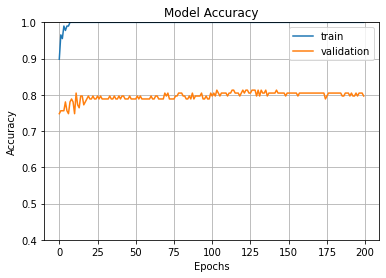

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

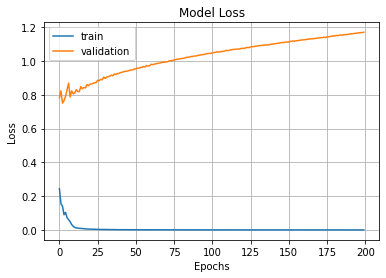

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Step 5: Membuat Prediksi

make predictions

In [ ]:
import cv2
image=cv2.imread(str(sel[0])) #ini harusnya normal_intermediate
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 180, 180, 3)


In [ ]:
#Hasil Prediksi per-kelas
pred=resnet_model.predict(image)
print(pred)

[[1.1167476e-08 3.1911879e-04 5.7952381e-08 9.9511826e-01 4.5626773e-03]]


In [ ]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is normal_intermediate


Making other predictions

In [ ]:
data_dir = "/content/drive/MyDrive/UAS_Siscer/Data/Testing"
data_dir = pathlib.Path(data_dir)
test = list(data_dir.glob('Carcinoma/153916114-153916167-002.BMP')) #Ngambil salah satu foto carcinoma

import cv2
image=cv2.imread(str(test[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 180, 180, 3)


In [ ]:
pred=resnet_model.predict(image)
print(pred)

[[9.9999678e-01 4.4248733e-07 2.7259905e-06 5.9979284e-09 2.0170290e-09]]


In [ ]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class) #harusnya carcinoma

The predicted class is carcinoma_in_situ
